In [14]:
#import jhu
import pandas as pd
import covid.util as util
print ("tmp")

tmp


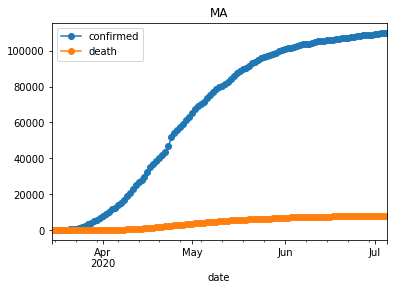

In [21]:
import matplotlib.pyplot as plt
US = util.jhu.load_us()
start = pd.Timestamp('2020-03-15')

US[0]['MA'][start:].plot(style='o-')
plt.title('MA')
plt.show()
vals = US[0]['MA'][start:]['death'].values

In [22]:
import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from jax import random, vmap

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 2000

#

import numpy as onp

def model(vals=None,t_future=0):
    rw = numpyro.sample("rw",dist.GaussianRandomWalk(scale=1, num_steps=len(vals)))
    d0 = numpyro.sample("d0",dist.Normal(vals[0],100))
    i_mean = np.exp(np.cumsum(rw)+d0)
    
    numpyro.sample('obs', dist.Normal(i_mean, 10), obs=vals)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, vals=vals[1:100])
mcmc.print_summary()
samples_1 = mcmc.get_samples()
    
    

sample: 100%|██████████| 3000/3000 [00:31<00:00, 94.63it/s, 1023 steps of size 2.28e-07. acc. prob=0.80] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        d0      1.08      0.00      1.08      1.08      1.08      0.50      1.00
     rw[0]      0.50      0.00      0.50      0.50      0.50      0.50      1.00
     rw[1]     -0.28      0.00     -0.28     -0.28     -0.28      0.50      1.00
     rw[2]      1.46      0.00      1.46      1.46      1.46      0.50      1.00
     rw[3]     -0.73      0.00     -0.73     -0.73     -0.73      0.50      1.00
     rw[4]      1.67      0.00      1.67      1.67      1.67      0.50      1.00
     rw[5]      0.56      0.00      0.56      0.56      0.56      0.50      1.00
     rw[6]     -0.20      0.00     -0.20     -0.20     -0.20      0.50      1.00
     rw[7]     -1.11      0.00     -1.11     -1.11     -1.11      0.50      1.00
     rw[8]     -0.90      0.00     -0.90     -0.90     -0.90      0.50      1.00
     rw[9]      0.28      0.00      0.28      0.28      0.28      0.50      1.00
    rw[10]     -0.54      0

In [23]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, vals=vals[1:100],t_future=20)['obs']


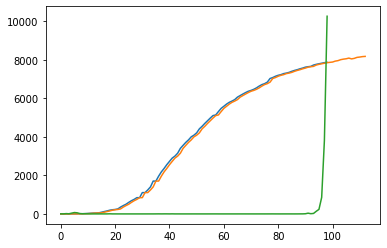

In [24]:
mean_rw = np.mean(samples_1["rw"],axis=0)
mean_d0 = np.mean(samples_1["d0"])
i_mean = onp.exp(onp.cumsum(mean_rw)+mean_d0)

plt.plot(np.mean(predictions,axis=0))
plt.plot(vals)
plt.plot(i_mean)
plt.show()